# March Madness Maching Learning v1.0
## Stacking Classifier Approach 

In [213]:
# Import the modules
from sklearn import model_selection, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from mlxtend.classifier import StackingClassifier
import pandas as pd 
import numpy as np

# Data Import

In [199]:
# Load the regular season data
rdf = pd.read_csv('./MMData/game_data_2016.csv')
tdf = pd.read_csv('./MMData/tournament_data_2016.csv')

# Uniformly and Randomly Sample the data
rdf = rdf.sample(frac=1)
tdf = tdf.sample(frac=1)

# Convert Boolean to integers
rdf['WL'] = rdf['WL'].apply(lambda x: 1 if x else 0)
tdf['WL'] = tdf['WL'].apply(lambda x: 1 if x else 0)

# Normalize the Features
mean = pd.concat((rdf['delta_Win_Percentage'], tdf['delta_Win_Percentage'])).mean()
std = pd.concat((rdf['delta_Win_Percentage'], tdf['delta_Win_Percentage'])).std()
rdf['delta_Win_Percentage']=(rdf['delta_Win_Percentage']-mean)/std
tdf['delta_Win_Percentage']=(tdf['delta_Win_Percentage']-mean)/std

mean = pd.concat((rdf['delta_Score_Margin'], tdf['delta_Score_Margin'])).mean()
std = pd.concat((rdf['delta_Score_Margin'], tdf['delta_Score_Margin'])).std()
rdf['delta_Score_Margin']=(rdf['delta_Score_Margin']-mean)/std
tdf['delta_Score_Margin']=(tdf['delta_Score_Margin']-mean)/std


X_train = rdf.as_matrix(['delta_Win_Percentage','delta_Score_Margin'])
y_train = rdf['WL'].tolist()

X_test = tdf.as_matrix(['delta_Win_Percentage','delta_Score_Margin'])
y_test = tdf['WL'].tolist()

# Display Summary
print("Regular Season Data Summary\n\tShape: %d,%d\n\t# Wins & Losses: %d,%d"%(X_train.shape[0],X_train.shape[1],np.bincount(y_train)[0],np.bincount(y_train)[1]))

print("\nTournament Data Summary\n\tShape: %d,%d\n\t# Wins & Losses: %d,%d"%(X_test.shape[0],X_test.shape[1],np.bincount(y_test)[0],np.bincount(y_test)[1]))

print(X_train)

Regular Season Data Summary
	Shape: 5369,2
	# Wins & Losses: 2835,2534

Tournament Data Summary
	Shape: 67,2
	# Wins & Losses: 38,29
[[ 0.89213869  0.7265961 ]
 [-0.43251902 -0.77990607]
 [-0.71861373 -1.19279926]
 ..., 
 [ 2.71060371  2.34469104]
 [ 0.26900089  1.08927255]
 [-1.18106819 -0.81226797]]


In [96]:
# Define function to save data
def SaveStage1Results(Data):
    return False

# Define Ensemble of Models

In [200]:
# Define Models to use in Stacked Classifier Ensemble Method

clf2 = RandomForestClassifier(random_state=1)
clf3 = GradientBoostingClassifier(random_state=1)
clf4 = GaussianNB()
lr = LogisticRegression()

# Grid Search Parameters
params = {'randomforestclassifier__n_estimators': [1, 50, 100, 200],
          'gradientboostingclassifier__n_estimators': [1, 50, 100, 200],
          'meta-logisticregression__C': [0.1, 1, 5, 10.0]}


sclf = StackingClassifier(classifiers=[clf2, clf3, clf4],
                          use_probas=True,
                          meta_classifier=lr)



# Train Model and Perform Cross Validation

In [214]:
# Train Models, using Cross-Validation
# w/o Grid Search of Hyperparameters
print('3-fold cross validation:\n')

tpred= []
tprob = []

for clf, label in zip([clf2, clf3, clf4, sclf],['Random Forest', 
                                                'Gradient Boosted', 
                                                'Naive Bayes',
                                                'StackingClassifier']):
    # Fit data using model
    clf.fit(X_train, y_train)
    
    # Compute Cross-Validation Score
    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"% (scores.mean(), scores.std(), label))
    
    # prediction class and probability
    tpred.append(clf.predict(X_test))
    tprob.append(clf.predict_proba(X_test))
    
    print(accuracy_score(clf.predict(X_test),y_test))


    
   

3-fold cross validation:

Accuracy: 0.66 (+/- 0.00) [Random Forest]
0.55223880597
Accuracy: 0.73 (+/- 0.00) [Gradient Boosted]
0.611940298507
Accuracy: 0.74 (+/- 0.00) [Naive Bayes]
0.746268656716
Accuracy: 0.64 (+/- 0.00) [StackingClassifier]
0.537313432836


In [202]:
# Train Models, using Cross-Validation
# w Grid Search of Hyperparameters

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X_train, y_train)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

KeyboardInterrupt: 

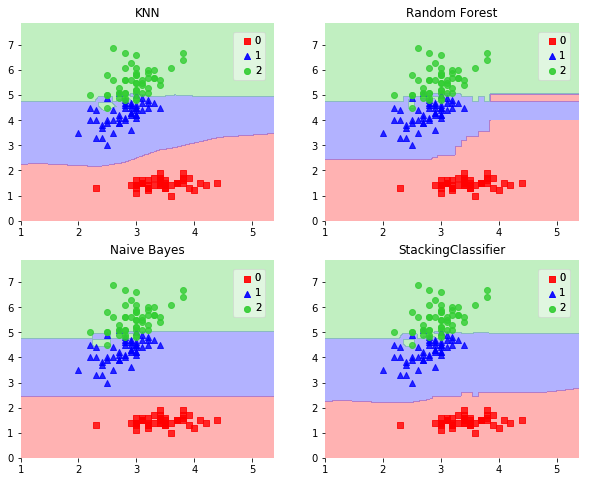

In [8]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
%matplotlib inline 

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['Random Forest', 
                          'Naive Bayes',
                          'StackingClassifier'],
                          itertools.product([0, 1], repeat=2)):

    clf.fit(X_train, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train, y=y_train, clf=clf)
    plt.title(lab)

In [212]:
print(tprob)


[array([[ 1.        ,  0.        ],
       [ 0.26666667,  0.73333333],
       [ 0.4       ,  0.6       ],
       [ 0.83333333,  0.16666667],
       [ 0.3       ,  0.7       ],
       [ 0.6       ,  0.4       ],
       [ 0.6       ,  0.4       ],
       [ 0.03333333,  0.96666667],
       [ 0.36047619,  0.63952381],
       [ 0.25      ,  0.75      ],
       [ 0.63333333,  0.36666667],
       [ 0.3       ,  0.7       ],
       [ 0.28333333,  0.71666667],
       [ 0.        ,  1.        ],
       [ 0.6       ,  0.4       ],
       [ 0.24      ,  0.76      ],
       [ 0.6       ,  0.4       ],
       [ 0.48333333,  0.51666667],
       [ 0.4       ,  0.6       ],
       [ 0.05      ,  0.95      ],
       [ 0.7       ,  0.3       ],
       [ 0.95      ,  0.05      ],
       [ 0.        ,  1.        ],
       [ 0.48      ,  0.52      ],
       [ 0.62916667,  0.37083333],
       [ 0.4375    ,  0.5625    ],
       [ 0.9       ,  0.1       ],
       [ 0.73333333,  0.26666667],
       [ 0.475     